# Load data

In [1]:
import shap  # https://github.com/slundberg/shap

import shapreg  # https://github.com/iancovert/shapley-regression
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import os
import dill
import matplotlib.pyplot as plt

/home/lcorbucci/private_fast_shap/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np
import matplotlib.pyplot as plt


# Plotting function
def plot_shapley_comparison(evals, mean_distances, std_errors, title):
    plt.figure(figsize=(20, 8))
    for method, mean in mean_distances.items():
        std_error = std_errors[method]
        plt.plot(evals, mean, label=method)
        mean = np.array(mean)
        std_error = np.array(std_error)
        plt.fill_between(evals, mean - std_error, mean + std_error, alpha=0.2)

    plt.xlabel("# Evals", fontsize=20)
    plt.ylabel("Mean $\\ell_2$ distance", fontsize=20)
    plt.title(title, fontsize=20)
    # put the legend outside the plot
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=20)

    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.grid(True)
    plt.show()

In [3]:
def load_model(model_name):
    if os.path.isfile(model_name):
        model = torch.load(model_name)
    else:
        raise FileNotFoundError("Model not found")
    return model

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# surrogate_DP = load_model("./train_explainer/surrogate_dp.pt").to(device)
surrogate = load_model("./train_explainer/surrogate.pt").to(device)

In [5]:
# Load and split data
X_train, X_test, Y_train, Y_test = train_test_split(
    *shap.datasets.adult(), test_size=0.2, random_state=42
)
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size=0.2, random_state=0
)

# Data scaling
num_features = X_train.shape[1]
feature_names = X_train.columns.tolist()
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train.values)
X_val = ss.transform(X_val.values)
X_test = ss.transform(X_test.values)

/home/lcorbucci/private_fast_shap/.venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/lcorbucci/private_fast_shap/.venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/lcorbucci/private_fast_shap/.venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [6]:
X_test.shape

(6513, 12)

# Compare with KernelSHAP

In [7]:
# Setup for KernelSHAP
def imputer(x, S):
    x = torch.tensor(x, dtype=torch.float32, device=device)
    S = torch.tensor(S, dtype=torch.float32, device=device)
    pred = surrogate((x, S)).softmax(dim=-1)
    return pred.cpu().data.numpy()

# Comparison with Surrogate 0.5

In [8]:
fastshap = dill.load(open("./train_explainer/fastshap_NO_DP.pkl", "rb"))
fastshap_dp_05 = dill.load(
    open("./train_explainer/fastshap_dp_05_surrogate_05.pkl", "rb")
)
fastshap_dp_1 = dill.load(
    open("./train_explainer/fastshap_dp_1_surrogate_05.pkl", "rb")
)
fastshap_dp_2 = dill.load(
    open("./train_explainer/fastshap_dp_2_surrogate_05.pkl", "rb")
)
fastshap_dp_5 = dill.load(
    open("./train_explainer/fastshap_dp_5_surrogate_05.pkl", "rb")
)

In [9]:
dumped_shap_values = dill.load(open("./shap_values.pkl", "rb"))
dumped_results = dill.load(open("./results.pkl", "rb"))
dumped_indexes = dill.load(open("./indexes.pkl", "rb"))

In [10]:
fastshap_values = []
fastshap_values_DP_05 = []
fastshap_values_DP_1 = []
fastshap_values_DP_2 = []
fastshap_values_DP_5 = []

for ind in dumped_indexes:
    x = X_test[ind : ind + 1]
    y = int(Y_test[ind])

    # Run FastSHAP
    fastshap_values.append(fastshap.shap_values(x)[0][:, y])
    fastshap_values_DP_05.append(fastshap_dp_05.shap_values(x)[0][:, y])
    fastshap_values_DP_1.append(fastshap_dp_1.shap_values(x)[0][:, y])
    fastshap_values_DP_2.append(fastshap_dp_2.shap_values(x)[0][:, y])
    fastshap_values_DP_5.append(fastshap_dp_5.shap_values(x)[0][:, y])

fastshap_values = np.array(fastshap_values)
fastshap_values_DP_05 = np.array(fastshap_values_DP_05)
fastshap_values_DP_1 = np.array(fastshap_values_DP_1)
fastshap_values_DP_2 = np.array(fastshap_values_DP_2)
fastshap_values_DP_5 = np.array(fastshap_values_DP_5)

In [11]:
results_mean = {
    "kernel_shap": [],
    "fastshap": [],
    "fastshap_DP_05": [],
    "fastshap_DP_1": [],
    "fastshap_DP_2": [],
    "fastshap_DP_5": [],
}

results_std = {
    "kernel_shap": [],
    "fastshap": [],
    "fastshap_DP_05": [],
    "fastshap_DP_1": [],
    "fastshap_DP_2": [],
    "fastshap_DP_5": [],
}

iters = []

for kernelshap_iters in range(32, 672, 32):
    true_shap_values = []
    kernel_shap_values = []

    for ind in dumped_indexes:
        x = X_test[ind : ind + 1]
        y = int(Y_test[ind])
        # get the SHAP values
        shap_values = dumped_shap_values[dumped_indexes.index(ind)]
        all_results = dumped_results[dumped_indexes.index(ind)]

        a = all_results["values"][list(all_results["iters"]).index(kernelshap_iters)]

        true_shap_values.append(shap_values.values[:, y])
        kernel_shap_values.append(
            all_results["values"][list(all_results["iters"]).index(kernelshap_iters)][
                :, y
            ]
        )

    true_shap_values = np.array(true_shap_values)
    kernel_shap_values = np.array(kernel_shap_values)

    for current_list in [
        (kernel_shap_values, "kernel_shap"),
        (fastshap_values, "fastshap"),
        (fastshap_values_DP_05, "fastshap_DP_05"),
        (fastshap_values_DP_1, "fastshap_DP_1"),
        (fastshap_values_DP_2, "fastshap_DP_2"),
        (fastshap_values_DP_5, "fastshap_DP_5"),
    ]:
        # Compute the L2 distances between corresponding vectors in the two arrays
        distances = np.linalg.norm(true_shap_values - current_list[0], axis=0)

        # Calculate the mean L2 distance
        mean_l2_distance = np.mean(distances)

        # Calculate the standard error of the L2 distances
        standard_error = np.std(distances) / np.sqrt(len(distances))

        results_mean[current_list[1]].append(mean_l2_distance)
        results_std[current_list[1]].append(standard_error)

    iters.append(kernelshap_iters)

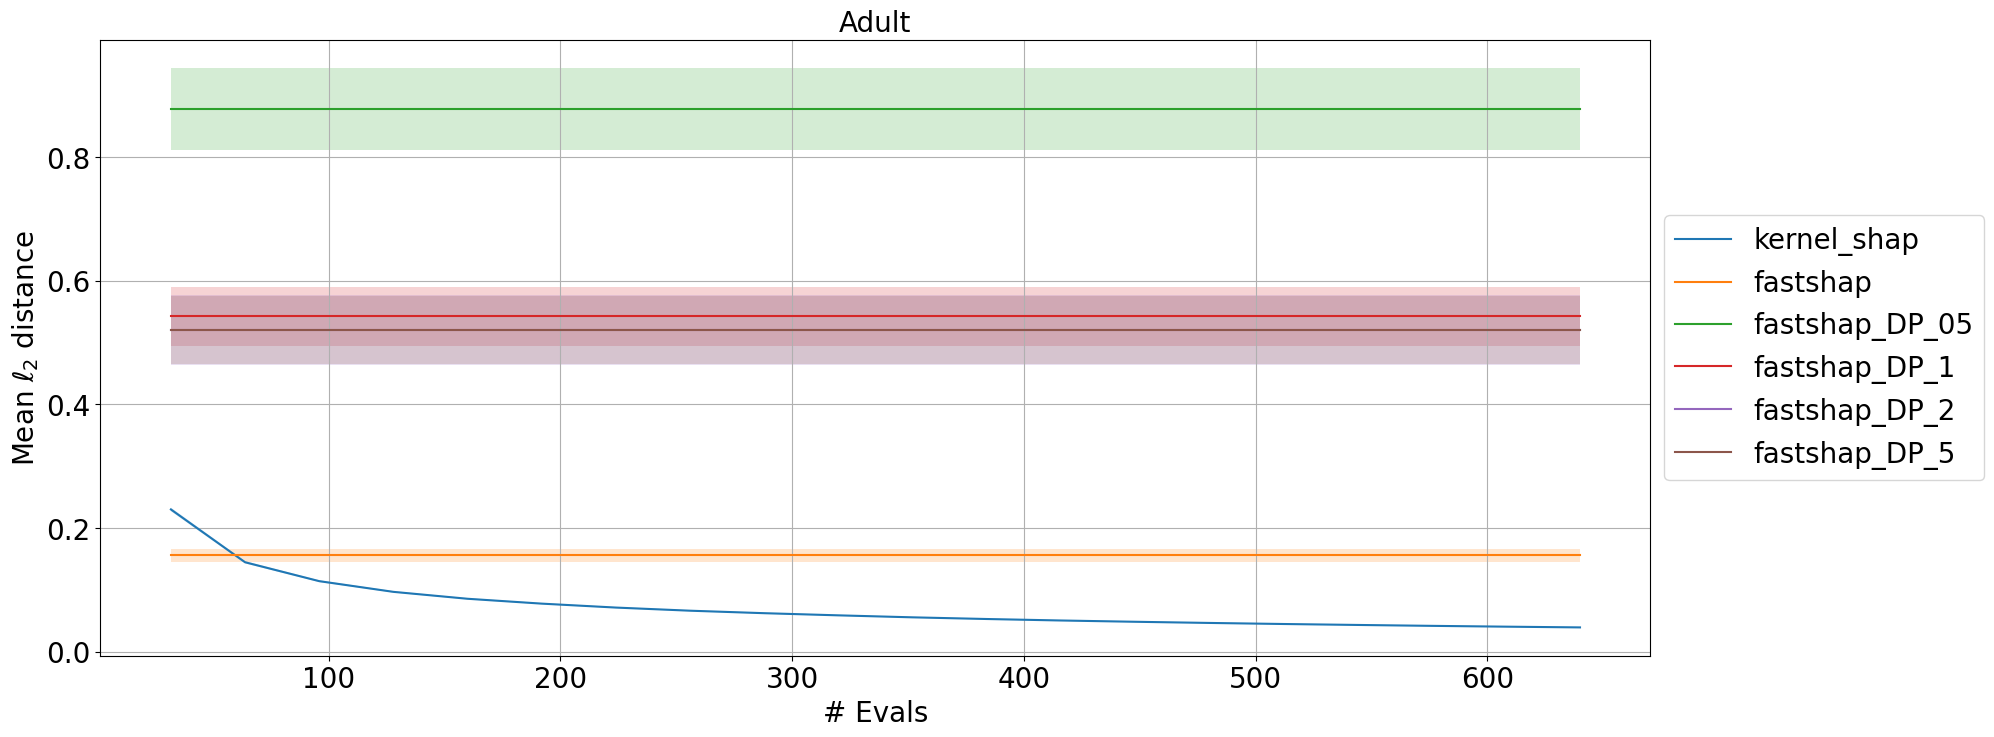

In [12]:
# Plot for News dataset
plot_shapley_comparison(iters, results_mean, results_std, "Adult")

# Surrogate with Epsilon = 5

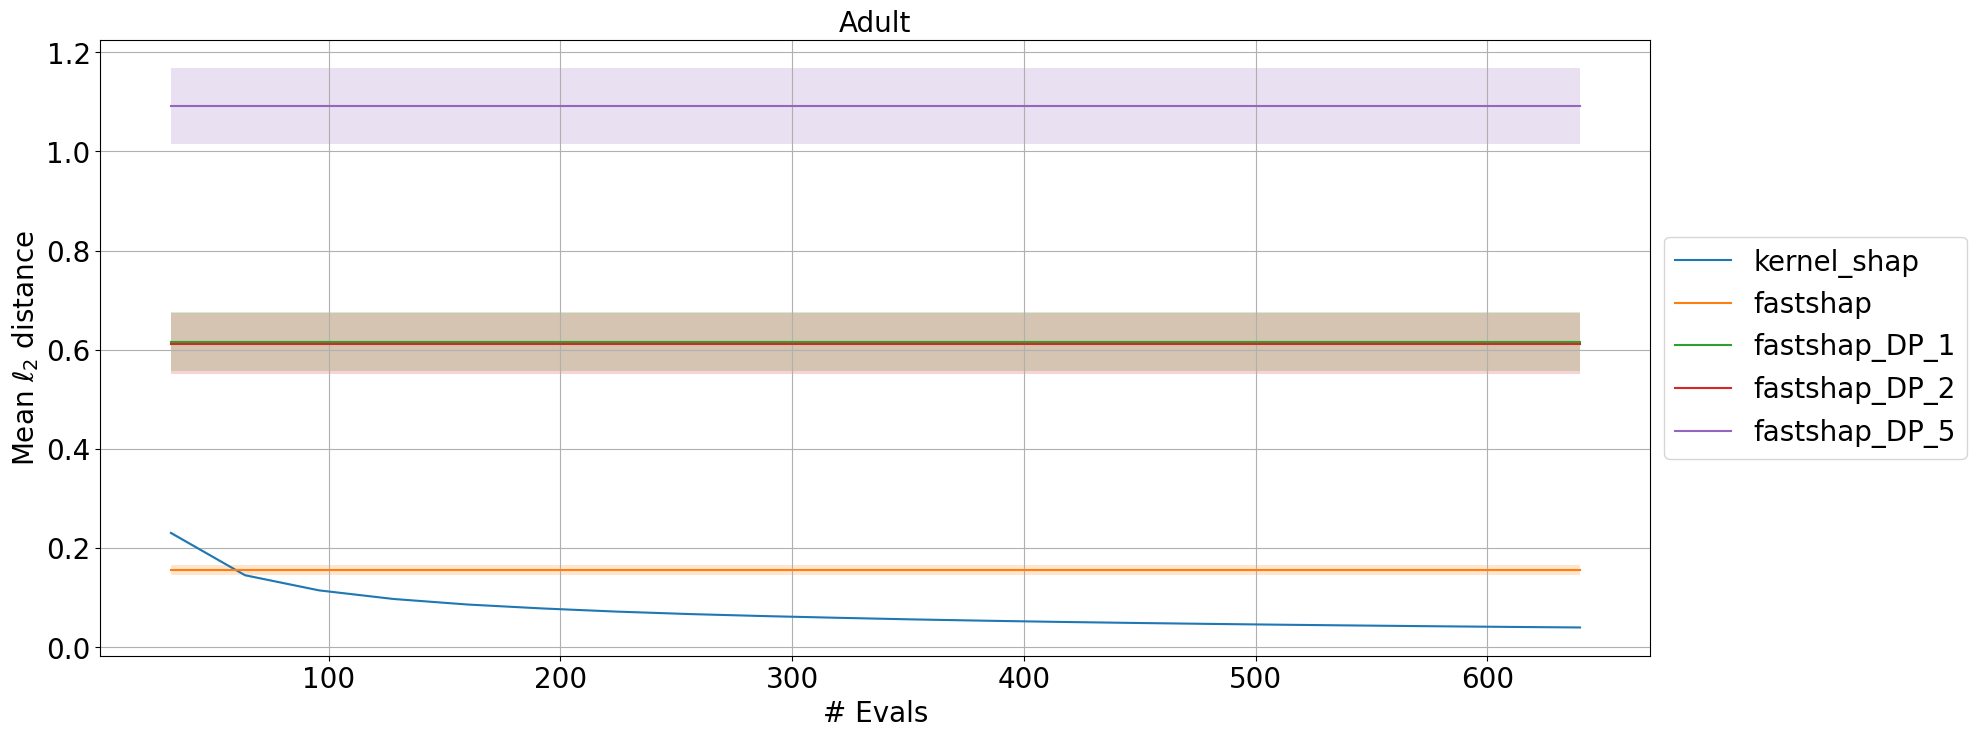

In [13]:
fastshap_dp_1 = dill.load(open("./train_explainer/fastshap_dp_1_surrogate_5.pkl", "rb"))
fastshap_dp_2 = dill.load(open("./train_explainer/fastshap_dp_2_surrogate_5.pkl", "rb"))
fastshap_dp_5 = dill.load(open("./train_explainer/fastshap_dp_5_surrogate_5.pkl", "rb"))

fastshap_values = []
fastshap_values_DP_05 = []
fastshap_values_DP_1 = []
fastshap_values_DP_2 = []
fastshap_values_DP_5 = []

for ind in dumped_indexes:
    x = X_test[ind : ind + 1]
    y = int(Y_test[ind])

    # Run FastSHAP
    fastshap_values.append(fastshap.shap_values(x)[0][:, y])
    fastshap_values_DP_05.append(fastshap_dp_05.shap_values(x)[0][:, y])
    fastshap_values_DP_1.append(fastshap_dp_1.shap_values(x)[0][:, y])
    fastshap_values_DP_2.append(fastshap_dp_2.shap_values(x)[0][:, y])
    fastshap_values_DP_5.append(fastshap_dp_5.shap_values(x)[0][:, y])

fastshap_values = np.array(fastshap_values)
fastshap_values_DP_05 = np.array(fastshap_values_DP_05)
fastshap_values_DP_1 = np.array(fastshap_values_DP_1)
fastshap_values_DP_2 = np.array(fastshap_values_DP_2)
fastshap_values_DP_5 = np.array(fastshap_values_DP_5)

results_mean = {
    "kernel_shap": [],
    "fastshap": [],
    "fastshap_DP_1": [],
    "fastshap_DP_2": [],
    "fastshap_DP_5": [],
}

results_std = {
    "kernel_shap": [],
    "fastshap": [],
    "fastshap_DP_1": [],
    "fastshap_DP_2": [],
    "fastshap_DP_5": [],
}

iters = []

for kernelshap_iters in range(32, 672, 32):
    true_shap_values = []
    kernel_shap_values = []

    for ind in dumped_indexes:
        x = X_test[ind : ind + 1]
        y = int(Y_test[ind])
        # get the SHAP values
        shap_values = dumped_shap_values[dumped_indexes.index(ind)]
        all_results = dumped_results[dumped_indexes.index(ind)]

        a = all_results["values"][list(all_results["iters"]).index(kernelshap_iters)]

        true_shap_values.append(shap_values.values[:, y])
        kernel_shap_values.append(
            all_results["values"][list(all_results["iters"]).index(kernelshap_iters)][
                :, y
            ]
        )

    true_shap_values = np.array(true_shap_values)
    kernel_shap_values = np.array(kernel_shap_values)

    for current_list in [
        (kernel_shap_values, "kernel_shap"),
        (fastshap_values, "fastshap"),
        (fastshap_values_DP_1, "fastshap_DP_1"),
        (fastshap_values_DP_2, "fastshap_DP_2"),
        (fastshap_values_DP_5, "fastshap_DP_5"),
    ]:
        # Compute the L2 distances between corresponding vectors in the two arrays
        distances = np.linalg.norm(true_shap_values - current_list[0], axis=0)

        # Calculate the mean L2 distance
        mean_l2_distance = np.mean(distances)

        # Calculate the standard error of the L2 distances
        standard_error = np.std(distances) / np.sqrt(len(distances))

        results_mean[current_list[1]].append(mean_l2_distance)
        results_std[current_list[1]].append(standard_error)

    iters.append(kernelshap_iters)

# Plot for News dataset
plot_shapley_comparison(iters, results_mean, results_std, "Adult")

# Epsilon = 100

In [14]:
# modello non DP e vedere kernel_shap vs fastshap tradizionale
# surrogato senza privacy e vedere come si comporta fastshap con DP

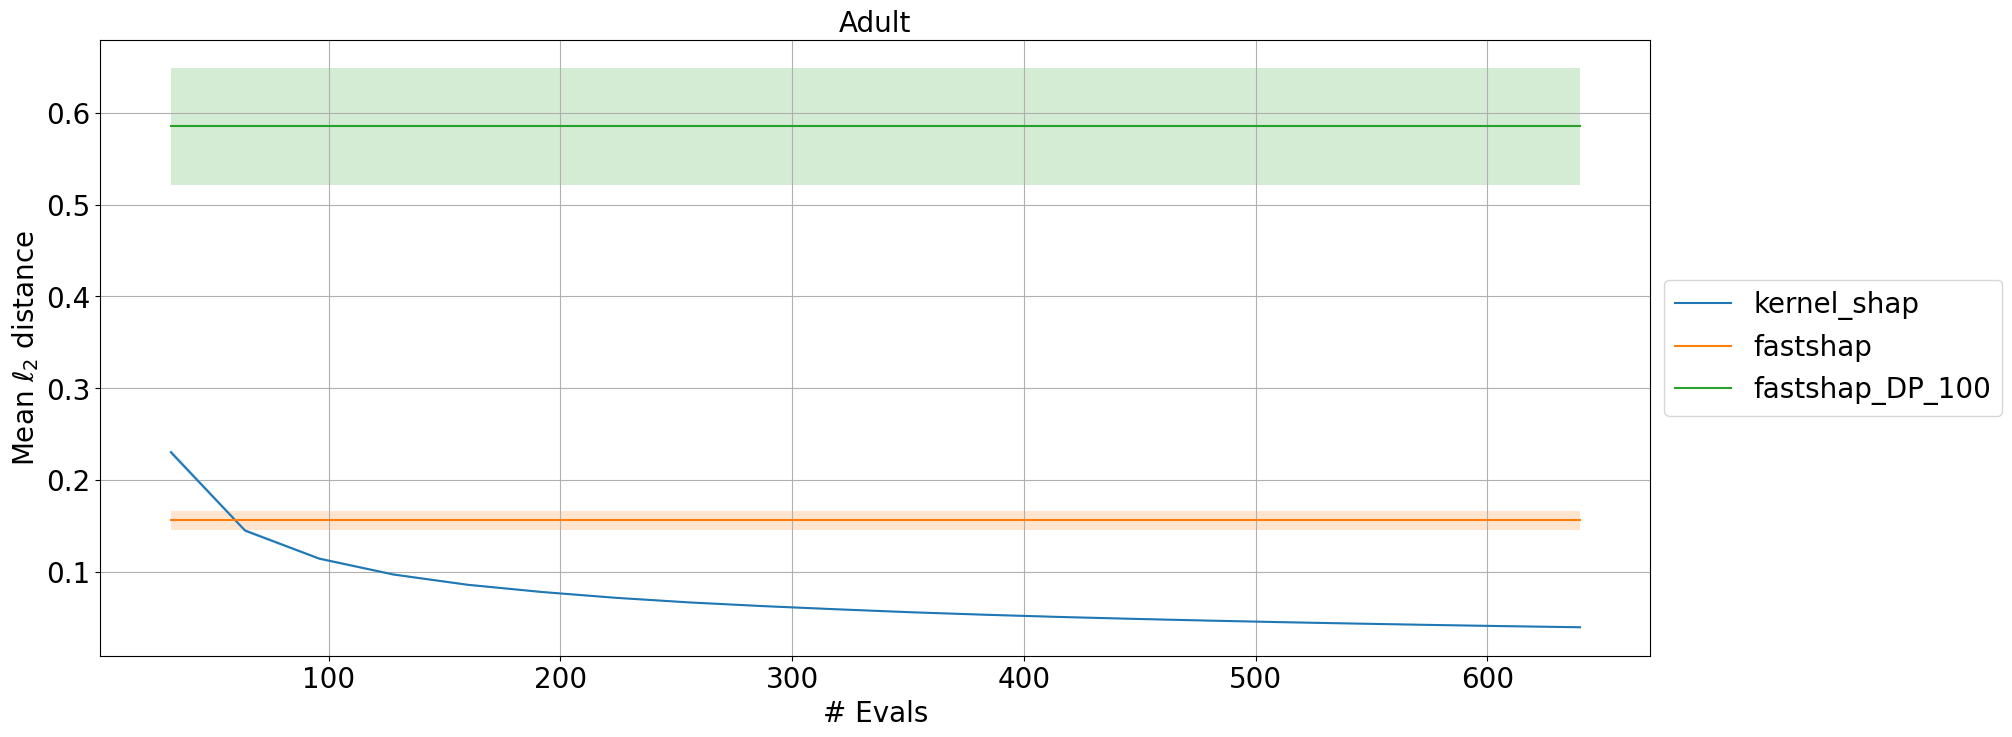

In [15]:
fastshap_dp_100 = dill.load(open("./train_explainer/fastshap_dp_100.pkl", "rb"))

fastshap_values = []
fastshap_values_DP_100 = []

for ind in dumped_indexes:
    x = X_test[ind : ind + 1]
    y = int(Y_test[ind])

    # Run FastSHAP
    fastshap_values.append(fastshap.shap_values(x)[0][:, y])
    fastshap_values_DP_100.append(fastshap_dp_100.shap_values(x)[0][:, y])

fastshap_values = np.array(fastshap_values)
fastshap_values_DP_100 = np.array(fastshap_values_DP_100)

results_mean = {
    "kernel_shap": [],
    "fastshap": [],
    "fastshap_DP_100": [],
}

results_std = {
    "kernel_shap": [],
    "fastshap": [],
    "fastshap_DP_100": [],
}

iters = []

for kernelshap_iters in range(32, 672, 32):
    true_shap_values = []
    kernel_shap_values = []

    for ind in dumped_indexes:
        x = X_test[ind : ind + 1]
        y = int(Y_test[ind])
        # get the SHAP values
        shap_values = dumped_shap_values[dumped_indexes.index(ind)]
        all_results = dumped_results[dumped_indexes.index(ind)]

        a = all_results["values"][list(all_results["iters"]).index(kernelshap_iters)]

        true_shap_values.append(shap_values.values[:, y])
        kernel_shap_values.append(
            all_results["values"][list(all_results["iters"]).index(kernelshap_iters)][
                :, y
            ]
        )

    true_shap_values = np.array(true_shap_values)
    kernel_shap_values = np.array(kernel_shap_values)

    for current_list in [
        (kernel_shap_values, "kernel_shap"),
        (fastshap_values, "fastshap"),
        (fastshap_values_DP_100, "fastshap_DP_100"),
    ]:
        # Compute the L2 distances between corresponding vectors in the two arrays
        distances = np.linalg.norm(true_shap_values - current_list[0], axis=0)

        # Calculate the mean L2 distance
        mean_l2_distance = np.mean(distances)

        # Calculate the standard error of the L2 distances
        standard_error = np.std(distances) / np.sqrt(len(distances))

        results_mean[current_list[1]].append(mean_l2_distance)
        results_std[current_list[1]].append(standard_error)

    iters.append(kernelshap_iters)

# Plot for News dataset
plot_shapley_comparison(iters, results_mean, results_std, "Adult")

# Light GBM Model

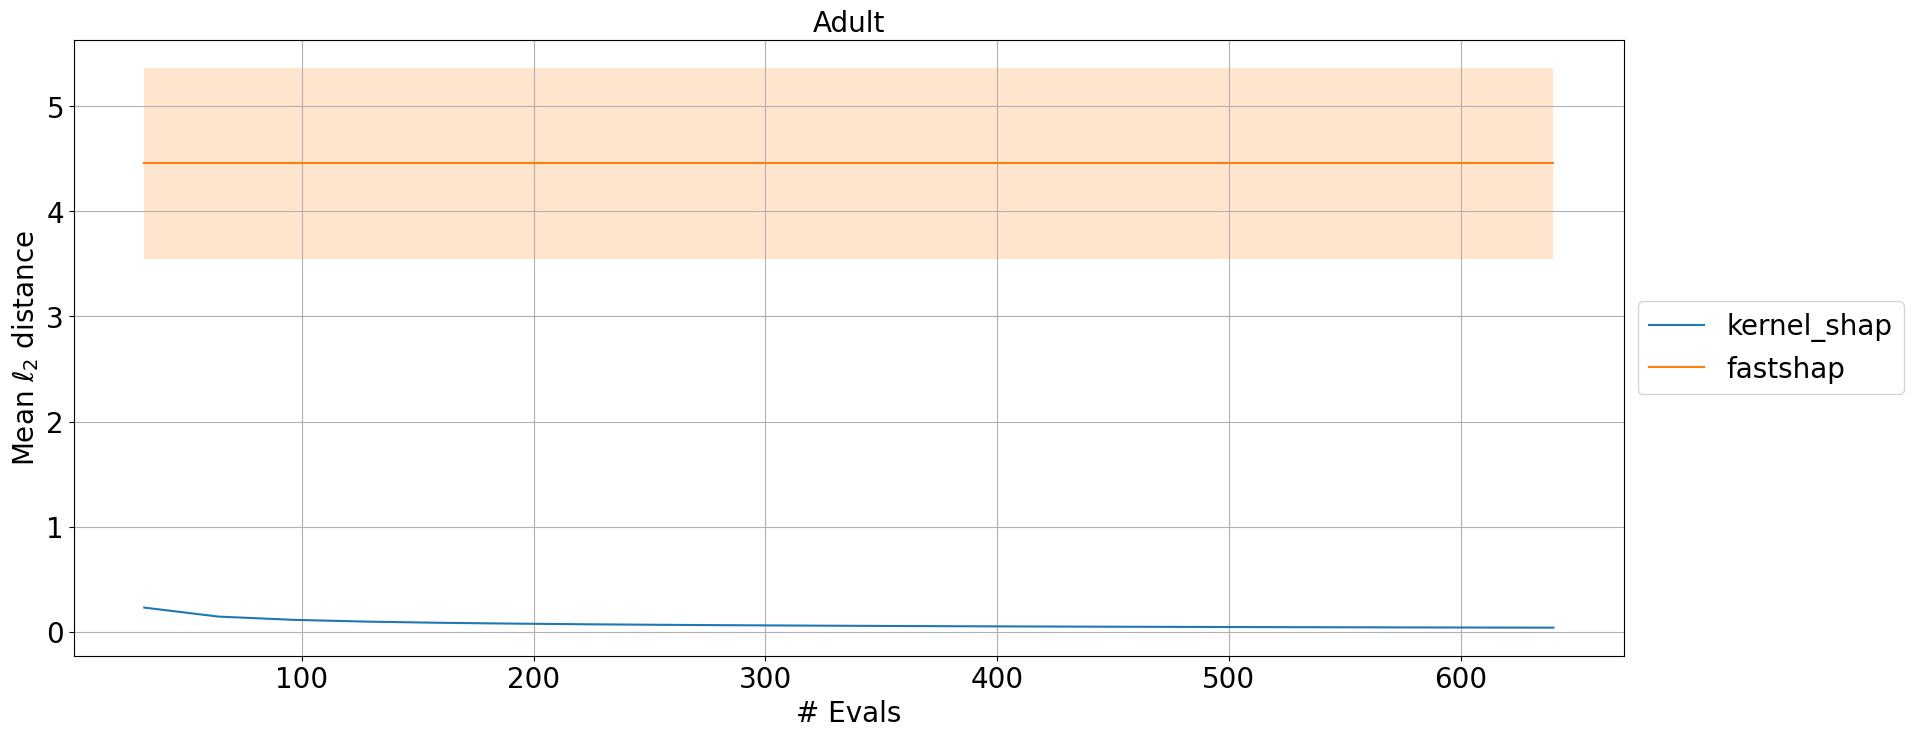

In [16]:
from fastshap import FastSHAP
import torch.nn as nn
from fastshap.surrogate import Surrogate


surr = torch.load("./original/surrogate.pt").to(device)
surrogate = Surrogate(surr, num_features)
explainer = torch.load("./original/explainer.pt").to(device)
fastshap_gbm = FastSHAP(
    explainer, surrogate, normalization="additive", link=nn.Softmax(dim=-1)
)
fastshap_values = []

for ind in dumped_indexes:
    x = X_test[ind : ind + 1]
    y = int(Y_test[ind])

    # Run FastSHAP
    fastshap_values.append(fastshap_gbm.shap_values(x)[0][:, y])

fastshap_values = np.array(fastshap_values)

results_mean = {
    "kernel_shap": [],
    "fastshap": [],
}

results_std = {
    "kernel_shap": [],
    "fastshap": [],
}

iters = []

for kernelshap_iters in range(32, 672, 32):
    true_shap_values = []
    kernel_shap_values = []

    for ind in dumped_indexes:
        x = X_test[ind : ind + 1]
        y = int(Y_test[ind])
        # get the SHAP values
        shap_values = dumped_shap_values[dumped_indexes.index(ind)]
        all_results = dumped_results[dumped_indexes.index(ind)]

        a = all_results["values"][list(all_results["iters"]).index(kernelshap_iters)]

        true_shap_values.append(shap_values.values[:, y])
        kernel_shap_values.append(
            all_results["values"][list(all_results["iters"]).index(kernelshap_iters)][
                :, y
            ]
        )

    true_shap_values = np.array(true_shap_values)
    kernel_shap_values = np.array(kernel_shap_values)

    for current_list in [
        (kernel_shap_values, "kernel_shap"),
        (fastshap_values, "fastshap"),
    ]:
        # Compute the L2 distances between corresponding vectors in the two arrays
        distances = np.linalg.norm(true_shap_values - current_list[0], axis=0)

        # Calculate the mean L2 distance
        mean_l2_distance = np.mean(distances)

        # Calculate the standard error of the L2 distances
        standard_error = np.std(distances) / np.sqrt(len(distances))

        results_mean[current_list[1]].append(mean_l2_distance)
        results_std[current_list[1]].append(standard_error)

    iters.append(kernelshap_iters)

# Plot for News dataset
plot_shapley_comparison(iters, results_mean, results_std, "Adult")

# Explainer con Privacy con Surrogato senza Privacy

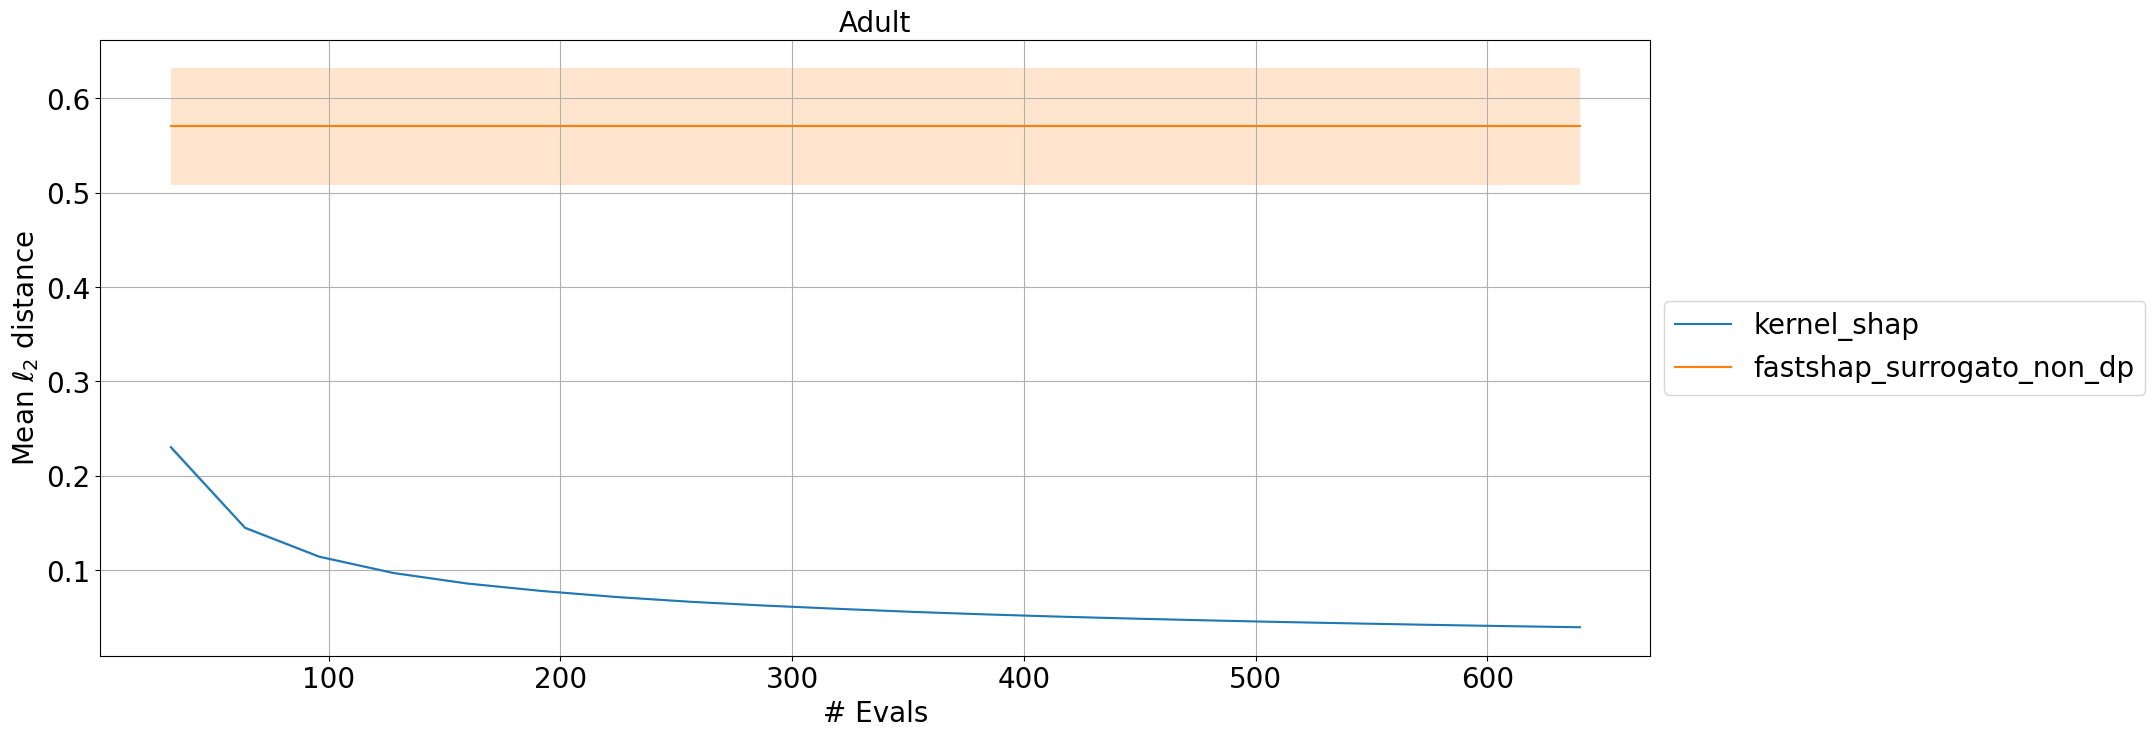

In [18]:
fastshap_surrogato_non_dp = dill.load(
    open("./train_explainer/explainer_surrogato_non_privato.pkl", "rb")
)

fastshap_surrogato_non_dp_values = []

for ind in dumped_indexes:
    x = X_test[ind : ind + 1]
    y = int(Y_test[ind])

    # Run FastSHAP
    fastshap_surrogato_non_dp_values.append(
        fastshap_surrogato_non_dp.shap_values(x)[0][:, y]
    )

fastshap_surrogato_non_dp_values = np.array(
    fastshap_surrogato_non_dp.shap_values(x)[0][:, y]
)

results_mean = {
    "kernel_shap": [],
    "fastshap_surrogato_non_dp": [],
}

results_std = {
    "kernel_shap": [],
    "fastshap_surrogato_non_dp": [],
}

iters = []

for kernelshap_iters in range(32, 672, 32):
    true_shap_values = []
    kernel_shap_values = []

    for ind in dumped_indexes:
        x = X_test[ind : ind + 1]
        y = int(Y_test[ind])
        # get the SHAP values
        shap_values = dumped_shap_values[dumped_indexes.index(ind)]
        all_results = dumped_results[dumped_indexes.index(ind)]

        a = all_results["values"][list(all_results["iters"]).index(kernelshap_iters)]

        true_shap_values.append(shap_values.values[:, y])
        kernel_shap_values.append(
            all_results["values"][list(all_results["iters"]).index(kernelshap_iters)][
                :, y
            ]
        )

    true_shap_values = np.array(true_shap_values)
    kernel_shap_values = np.array(kernel_shap_values)

    for current_list in [
        (kernel_shap_values, "kernel_shap"),
        (fastshap_surrogato_non_dp_values, "fastshap_surrogato_non_dp"),
    ]:
        # Compute the L2 distances between corresponding vectors in the two arrays
        distances = np.linalg.norm(true_shap_values - current_list[0], axis=0)

        # Calculate the mean L2 distance
        mean_l2_distance = np.mean(distances)

        # Calculate the standard error of the L2 distances
        standard_error = np.std(distances) / np.sqrt(len(distances))

        results_mean[current_list[1]].append(mean_l2_distance)
        results_std[current_list[1]].append(standard_error)

    iters.append(kernelshap_iters)

# Plot for News dataset
plot_shapley_comparison(iters, results_mean, results_std, "Adult")

# Explainer con Privacy con Modello e Surrogato senza privacy

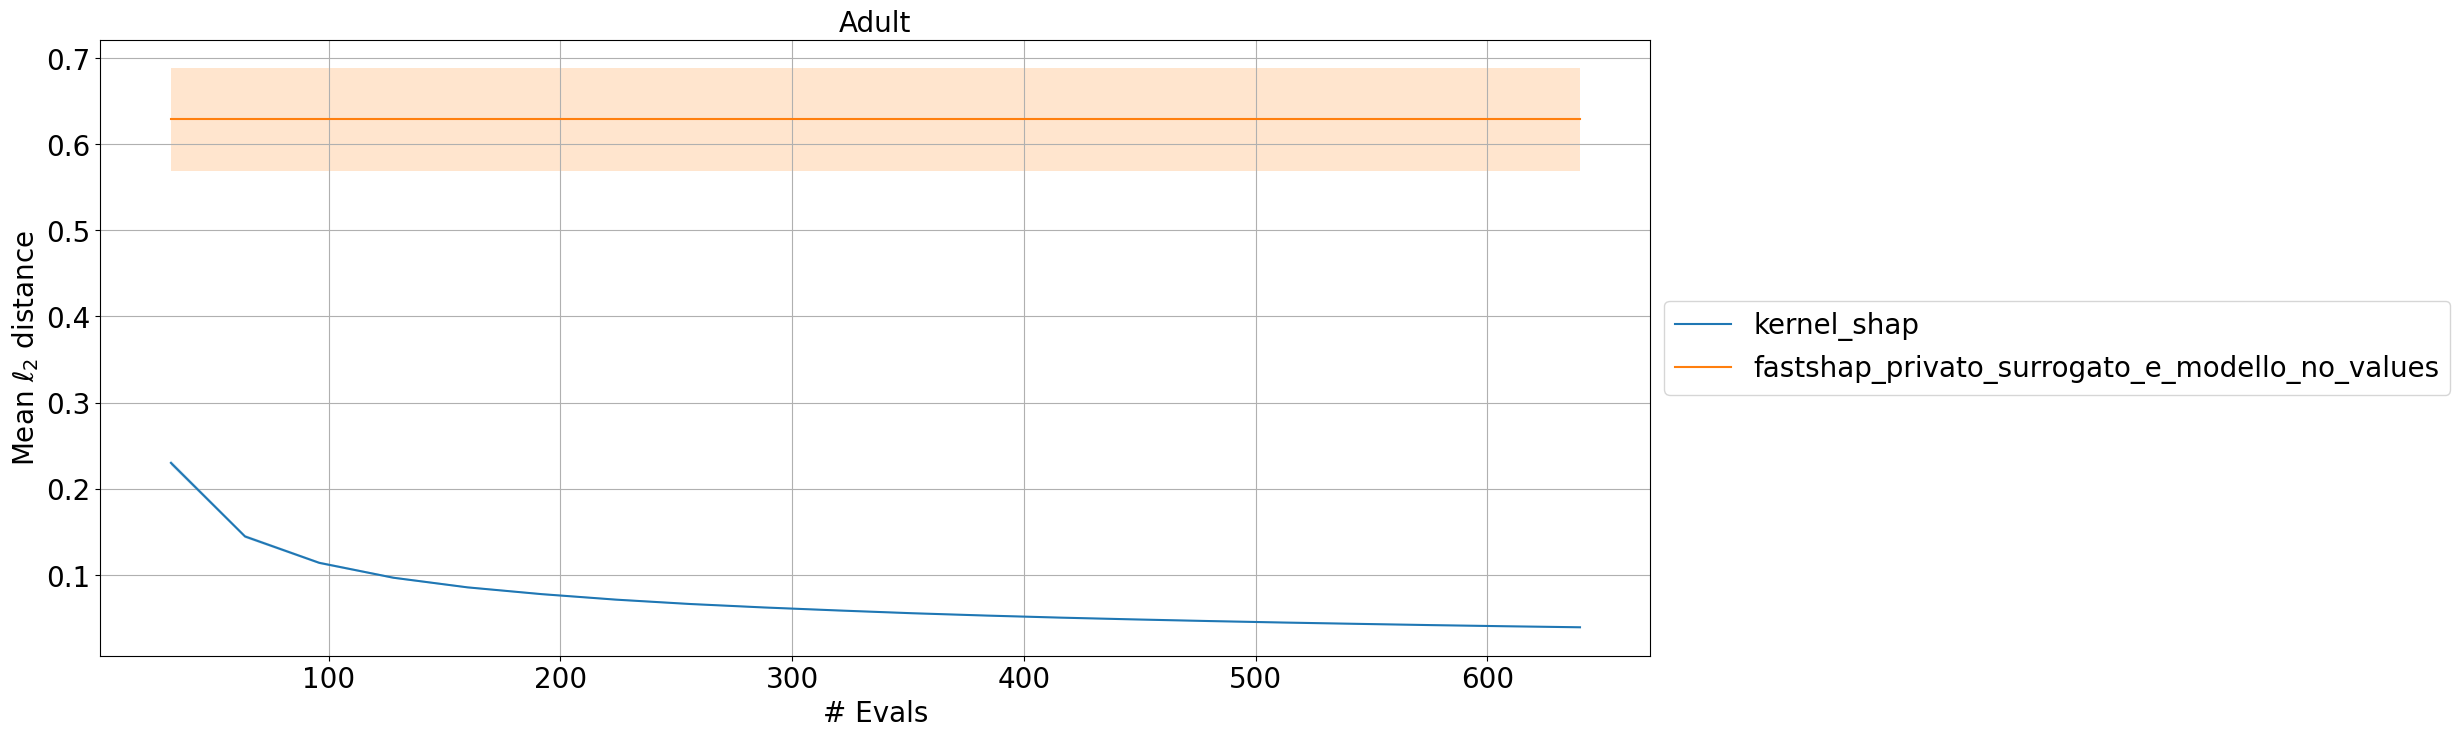

In [20]:
fastshap_privato_surrogato_e_modello_no = dill.load(
    open("./train_explainer/explainer_surrogato_non_privato.pkl", "rb")
)

fastshap_privato_surrogato_e_modello_no_values = []

for ind in dumped_indexes:
    x = X_test[ind : ind + 1]
    y = int(Y_test[ind])

    # Run FastSHAP
    fastshap_privato_surrogato_e_modello_no_values.append(
        fastshap_privato_surrogato_e_modello_no.shap_values(x)[0][:, y]
    )

fastshap_privato_surrogato_e_modello_no_values = np.array(
    fastshap_privato_surrogato_e_modello_no_values
)

results_mean = {
    "kernel_shap": [],
    "fastshap_privato_surrogato_e_modello_no_values": [],
}

results_std = {
    "kernel_shap": [],
    "fastshap_privato_surrogato_e_modello_no_values": [],
}

iters = []

for kernelshap_iters in range(32, 672, 32):
    true_shap_values = []
    kernel_shap_values = []

    for ind in dumped_indexes:
        x = X_test[ind : ind + 1]
        y = int(Y_test[ind])
        # get the SHAP values
        shap_values = dumped_shap_values[dumped_indexes.index(ind)]
        all_results = dumped_results[dumped_indexes.index(ind)]

        a = all_results["values"][list(all_results["iters"]).index(kernelshap_iters)]

        true_shap_values.append(shap_values.values[:, y])
        kernel_shap_values.append(
            all_results["values"][list(all_results["iters"]).index(kernelshap_iters)][
                :, y
            ]
        )

    true_shap_values = np.array(true_shap_values)
    kernel_shap_values = np.array(kernel_shap_values)

    for current_list in [
        (kernel_shap_values, "kernel_shap"),
        (
            fastshap_privato_surrogato_e_modello_no_values,
            "fastshap_privato_surrogato_e_modello_no_values",
        ),
    ]:
        # Compute the L2 distances between corresponding vectors in the two arrays
        distances = np.linalg.norm(true_shap_values - current_list[0], axis=0)

        # Calculate the mean L2 distance
        mean_l2_distance = np.mean(distances)

        # Calculate the standard error of the L2 distances
        standard_error = np.std(distances) / np.sqrt(len(distances))

        results_mean[current_list[1]].append(mean_l2_distance)
        results_std[current_list[1]].append(standard_error)

    iters.append(kernelshap_iters)

# Plot for News dataset
plot_shapley_comparison(iters, results_mean, results_std, "Adult")

# Niente Privacy

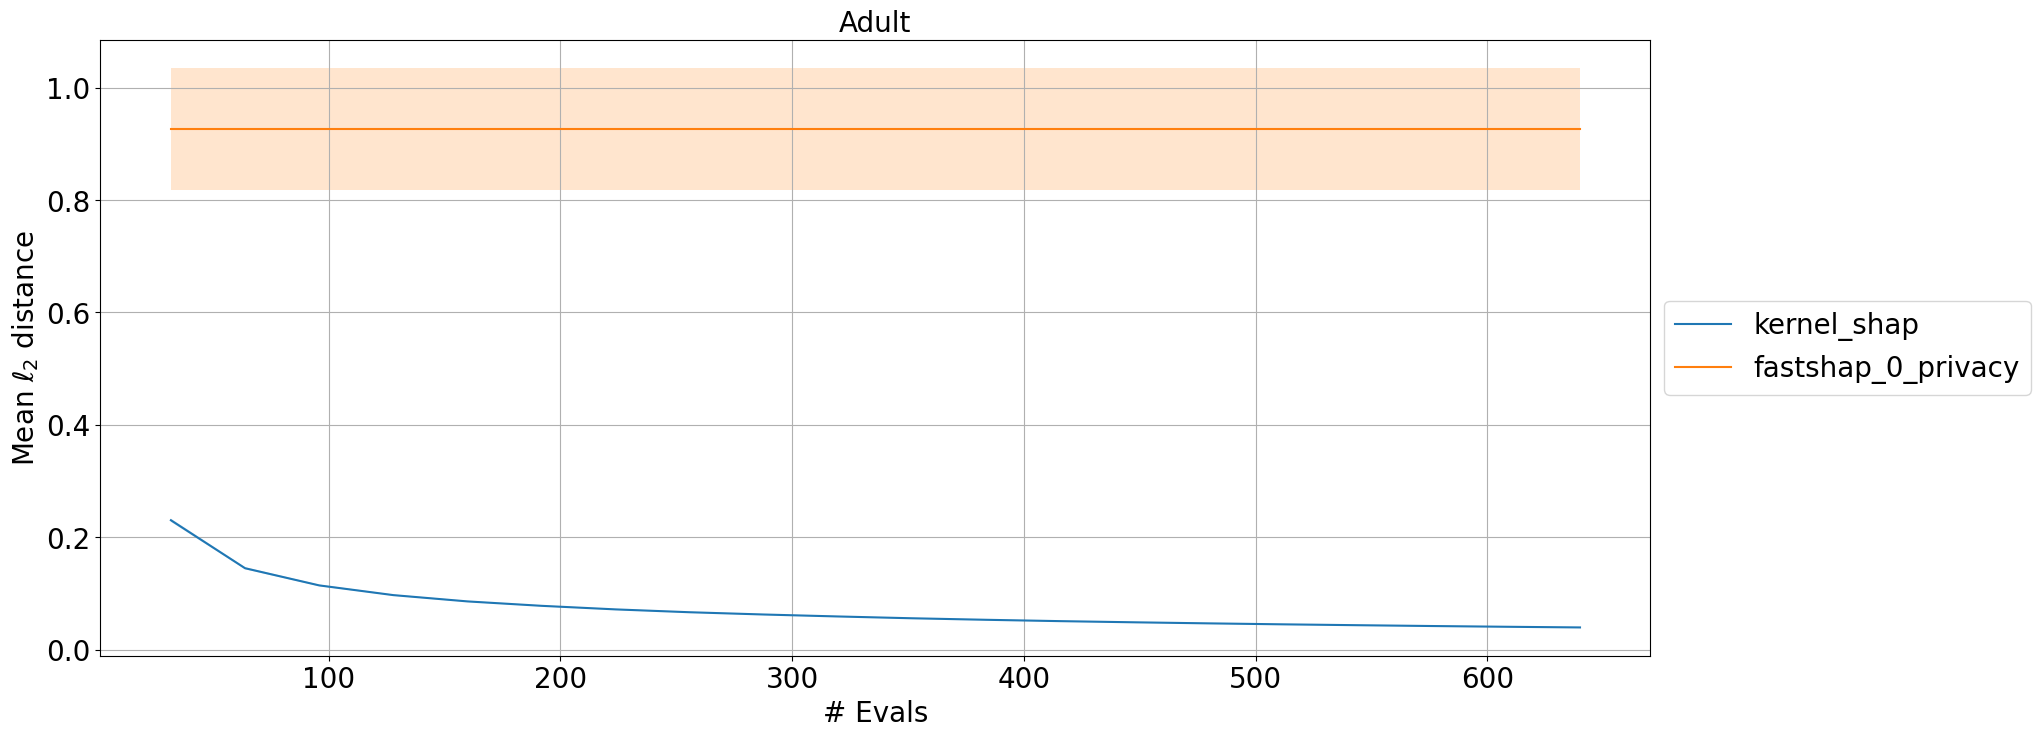

In [21]:
fastshap_0_privacy = dill.load(open("./train_explainer/explainer_0_privacy.pkl", "rb"))

fastshap_0_privacy_values = []

for ind in dumped_indexes:
    x = X_test[ind : ind + 1]
    y = int(Y_test[ind])

    # Run FastSHAP
    fastshap_0_privacy_values.append(fastshap_0_privacy.shap_values(x)[0][:, y])

fastshap_0_privacy_values = np.array(fastshap_0_privacy_values)

results_mean = {
    "kernel_shap": [],
    "fastshap_0_privacy": [],
}

results_std = {
    "kernel_shap": [],
    "fastshap_0_privacy": [],
}

iters = []

for kernelshap_iters in range(32, 672, 32):
    true_shap_values = []
    kernel_shap_values = []

    for ind in dumped_indexes:
        x = X_test[ind : ind + 1]
        y = int(Y_test[ind])
        # get the SHAP values
        shap_values = dumped_shap_values[dumped_indexes.index(ind)]
        all_results = dumped_results[dumped_indexes.index(ind)]

        a = all_results["values"][list(all_results["iters"]).index(kernelshap_iters)]

        true_shap_values.append(shap_values.values[:, y])
        kernel_shap_values.append(
            all_results["values"][list(all_results["iters"]).index(kernelshap_iters)][
                :, y
            ]
        )

    true_shap_values = np.array(true_shap_values)
    kernel_shap_values = np.array(kernel_shap_values)

    for current_list in [
        (kernel_shap_values, "kernel_shap"),
        (fastshap_0_privacy_values, "fastshap_0_privacy"),
    ]:
        # Compute the L2 distances between corresponding vectors in the two arrays
        distances = np.linalg.norm(true_shap_values - current_list[0], axis=0)

        # Calculate the mean L2 distance
        mean_l2_distance = np.mean(distances)

        # Calculate the standard error of the L2 distances
        standard_error = np.std(distances) / np.sqrt(len(distances))

        results_mean[current_list[1]].append(mean_l2_distance)
        results_std[current_list[1]].append(standard_error)

    iters.append(kernelshap_iters)

# Plot for News dataset
plot_shapley_comparison(iters, results_mean, results_std, "Adult")

In [ ]:
# Select example
ind = np.random.choice(len(X_test))
if ind in dumped_indexes:
    x = X_test[ind : ind + 1]
    y = int(Y_test[ind])
    shap_values = dumped_shap_values[dumped_indexes.index(ind)]
    all_results = dumped_results[dumped_indexes.index(ind)]
    # Run FastSHAP
    fastshap_values = fastshap.shap_values(x)[0]
    fastshap_values_DP_05 = fastshap_dp_05.shap_values(x)[0]
    fastshap_values_DP_1 = fastshap_dp_1.shap_values(x)[0]
    fastshap_values_DP_2 = fastshap_dp_2.shap_values(x)[0]
    fastshap_values_DP_5 = fastshap_dp_5.shap_values(x)[0]
else:
    raise ValueError("Index not found")

# Create figure
plt.figure(figsize=(15, 8))

# Bar chart
width = 0.75
kernelshap_iters = 128
plt.bar(
    np.arange(num_features) - width / 7,
    shap_values.values[:, y],
    width / 7,
    label="True SHAP values",
    color="tab:gray",
)
plt.bar(
    np.arange(num_features),
    fastshap_values[:, y],
    width / 7,
    label="FastSHAP",
    color="tab:green",
)

plt.bar(
    np.arange(num_features) + width / 7,
    fastshap_values_DP_05[:, y],
    width / 7,
    label="FastSHAP DP - 0.5",
    color="tab:blue",
)
plt.bar(
    np.arange(num_features) + 2 * (width / 7),
    fastshap_values_DP_1[:, y],
    width / 7,
    label="FastSHAP DP - 1",
    color="tab:pink",
)
plt.bar(
    np.arange(num_features) + 3 * (width / 7),
    fastshap_values_DP_2[:, y],
    width / 7,
    label="FastSHAP DP - 2",
    color="tab:orange",
)
plt.bar(
    np.arange(num_features) + 4 * (width / 7),
    fastshap_values_DP_5[:, y],
    width / 7,
    label="FastSHAP DP - 5",
    color="tab:olive",
)

plt.bar(
    np.arange(num_features) + 5 * (width / 7),
    all_results["values"][list(all_results["iters"]).index(kernelshap_iters)][:, y],
    width / 7,
    label="KernelSHAP @ {}".format(kernelshap_iters),
    color="tab:red",
)

# Annotations
plt.legend(fontsize=16)
plt.tick_params(labelsize=14)
plt.ylabel("SHAP Values", fontsize=16)
plt.title("Census Explanation Example", fontsize=18)
plt.xticks(
    np.arange(num_features),
    feature_names,
    rotation=35,
    rotation_mode="anchor",
    ha="right",
)

plt.tight_layout()
plt.show()